# Assignment - Unsupervised Learning
This assignment is for Big Data in Finance II.

# 0: Setup
Download the lending club data saved on the hub as 
*/Data/lendingclub_cleaned/Loan_data.csv*.

Keep the following list of borrower characteristics:

`[loan_amnt, int_rate, annual_inc, avg_cur_bal, emp_length, fico_range_high, delinq_amnt, revol_util]`

Also keep `loan_status` and convert it into a default indicator (which is one if the loan status is "Fail")

In [ ]:
% matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression

np.seterr(all='ignore')
np.random.seed(123)

In [2]:
# load data
df = pd.read_csv('../data/lendingclub_cleaned/Loan_data.csv', low_memory = False, index_col=0)

# keep a list of certain borrower characteristers
clist = ['loan_status', 'loan_amnt', 'int_rate', 'annual_inc', 'avg_cur_bal', 'emp_length', 'fico_range_high', 'delinq_amnt', 'revol_util']
df = df[clist] # filter out the dataframe keeping only columns specified in list

# turn loan_status into a default indicator
df['loan_status'] = (df['loan_status'] == 'Fail')

# inspect data information
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107260 entries, 126413292 to 118607680
Data columns (total 9 columns):
loan_status        107260 non-null bool
loan_amnt          107260 non-null float64
int_rate           107260 non-null float64
annual_inc         107260 non-null float64
avg_cur_bal        107260 non-null float64
emp_length         107260 non-null int64
fico_range_high    107260 non-null float64
delinq_amnt        107260 non-null float64
revol_util         107260 non-null float64
dtypes: bool(1), float64(7), int64(1)
memory usage: 7.5 MB


# 1: Principal Components
Compute the first 2 principal components.

Make a biplot and interpret the main sources of variation in the data.

In [3]:
# The first two principal components
pca = PCA(n_components = 2)
da = df.iloc[:, 1:] # access data except column loan_status
da_nm = (da - da.mean())/da.std() # normalised data
pc = pca.fit_transform(da_nm)
print(pc)
print(pc.shape)

[[ 1.37079287e+00  2.43813723e+00]
 [ 3.06931385e-01 -1.07796849e+00]
 [-2.88516733e-01  2.55066383e+00]
 ...
 [ 1.25394671e+00 -5.62558139e-01]
 [ 8.62962675e-04  6.35329667e-01]
 [ 1.40613865e+00 -7.48712647e-01]]
(107260, 2)


Text(0,0.5,'Second principal component')

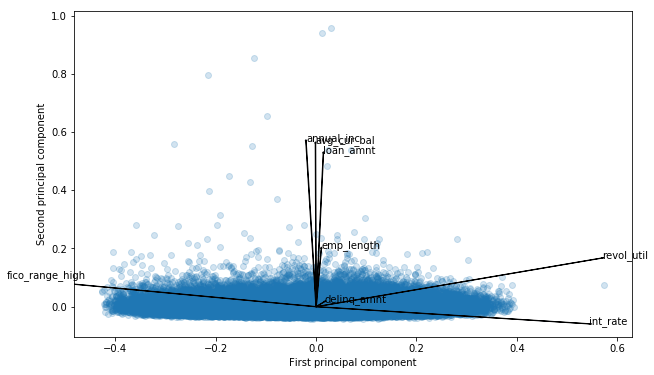

In [4]:
# Plot biplot
terms = da.sum(axis = 0).sort_values(ascending = False).index.tolist()
loadings = pd.DataFrame(pca.components_, index = ["PC1", "PC2"], columns = da.columns)
plt.figure(figsize=(10,6))
for term in terms:
    plt.arrow(0,0,loadings.loc['PC1',term],loadings.loc['PC2',term])
    plt.text(loadings.loc['PC1',term],loadings.loc['PC2',term],term)
plt.scatter(pc[:,0]/(pc[:,0].max() - pc[:,0].min()) ,pc[:,1]/(pc[:,1].max() - pc[:,1].min()),alpha = 0.2)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')

<div style="text-align:justify;">In the bi-plot we have the score of each observation on the first two principal components and the loading of each of the borrower characteristics for the first two principal components. We can analyse this graph by looking at each principal component, starting with the first PC, and then we will be able to apply this analysis to our four clusters.</div>

<div style="text-align:justify;">The rationale of PCA is projecting high dimension data to lower dimension in order to reduce the overwhelming number of dimensions while maintaining the variation of orginal variables. Such variation can be depicted by biplot which shows how strong each features affect principal components and how each variable is correlated.</div>
    

### First Principal Component
<br>
<div style="text-align:justify;">
The three main characteristics that drive the first PC are the <b>FICO upper range, revolving utilisation and interest rate given to the borrower at loan origination</b>. This suggests that these three factors are the most important in calculating the first PC, whereas the remaining five borrower characteristics are not as important factors for determining the first PC. Among the three most important characteristics for the first PC, FICO upper range appears to be the most important, although it is negatively correlated with revolving utilisation and interest rate given (the latter two characteristics are positively correlated), in other words, the higher the FICO score, the lower the revolving utilisation or interest rate, which is reasonable.</div>
<br>
<div style="text-align:justify;">
Knowing that these are three characteristics driving the first PC, we can deduce that <b>the first PC provides information on a borrower's general credit-worthiness</b>, in terms of credit history and current usage of credit. The FICO score uses a lot of historical data about a borrower in order to assess their risk, including payment history, amount owed, length of history and types of credit used. The revolving utilisation refers to the amount of credit the borrower is currently using relative to all available revolving credit. If a borrower is using most of the credit available to them, it is likely they would be less able to pay off another loan sustainably, and may have troubles making interest payments. Finally, the interest rate is a good proxy for the Lending Club grade, as they provide interest rates depending on the grade allocation, and as mentioned earlier, the Lending Club grade uses their own analysis to produce risk profiles on borrowers. Therefore, the first PC is a measure of a borrower's credit history and usage of credit currently.

### Second Principal Component
<br>
<div style="text-align:justify;">
The remaining five borrower characteristics appear to affect the second PC only, with delinquency amount having a small affect on both principal components. Annual income, average current balance, loan amount and employment length are closely correlated variables, with the former three being the most important factor in determining the second PC. We can therefore make a conjecture that <b>the second PC relates to the general financial stability of the borrower</b>. These characteristics assess how healthy the borrower's financials are, in relation to job stability, current bank balances and their salary. The biplot reveals that these characteristics are closely correlated with the loan amount that the borrower requests, and that, aside from employment length, they are all equally important for calculating the second PC. If a borrower has a healthy salary, a stable job (indicated by employment length) and a cash surplus in his bank accounts they are likely to be financially stable and able to request larger loan amounts. Additionally, these financial stability factors are uncorrelated with the credit history of the borrower (from first PC). It should be noted that the revolving utilisation also plays a smaller factor in driving the second principal component, but less so compared to the main stability factors.

### Summary

In our case, `delinq_amnt` hardly affects both two PCs; `fico_range_high`, `revol_util` and `int_rate` seem to have a stronger influnece on the first principal compenent while `loan_amnt`, `emp_length`, `annual_inc` and `avg_cur_bal` exert more significant impacts on the second principal component. 

In terms of correlation between variables, `loan_amnt`, `emp_length`, `annual_inc` and `avg_cur_bal` seem to be strongly positively correlated as they all point in the same direction. The plot also implied negative correlation of `fico_range_high` with `int_rate` and `revol_util`. 

# 2: Visualize Variation
Make a table with the percentage of variance explained by q
principal components. (q = 1 to 8)

Choose suitable number of principal components used in classification.

     Cumulative % of Variance Explained
PC1                            0.232213
PC2                            0.427368
PC3                            0.552442
PC4                            0.675551
PC5                            0.780523
PC6                            0.873105
PC7                            0.947673
PC8                            1.000000


Text(0,0.5,'Percentage of Variance Explained')

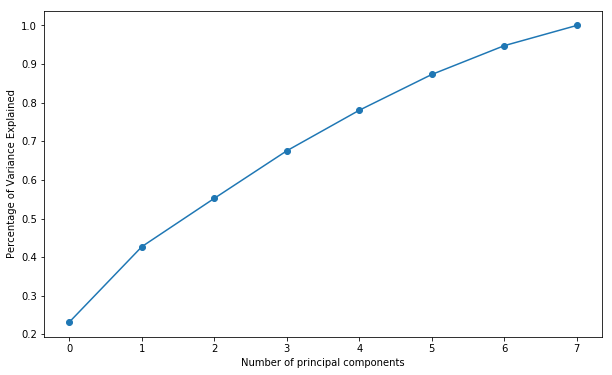

In [5]:
names = ["PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8"]
pca = PCA(n_components=8)

pc = pca.fit_transform(da_nm)
var_explained = np.cumsum(pca.explained_variance_ratio_)
var_explained_df = pd.DataFrame(var_explained, index = names, columns = ["Cumulative % of Variance Explained"])
print(var_explained_df)

# Scree plot
plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'-o')
plt.xlabel('Number of principal components')
plt.ylabel('Percentage of Variance Explained')

# 3 Prediction
Reallocate the dataset into 80% traning set, 10% validation set, 10% test set.
Create a synthetic dataset by undersampling non-defaulters(<70%).

Run 8 logistic classifiers that predict default as a function of the first q principal components.

In [6]:
# Split the data into training, validation and testing sets and undersample the training set

status = df.loc[:,'loan_status']

prob_val = [] # the implied probability of validation set for each q
prob_test = [] # the implied probability of testing set for each q
loss_val = [] # the cross-entropy loss for each q in validation set
loss_test = [] # the cross-entropy loss for each q in testing set
status_pred = [] # the predicted status of loans for each q

for q in range(8):
    dat = pc[:, 0:(q+1)] # Use the first q+1 principal components as input variables
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(dat, status, test_size=0.1, random_state=1, shuffle = True)
    # Split training set further to training set and validatiion set
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1, shuffle = True)
    # Undersample the training set
    rus = RandomUnderSampler(random_state=0, replacement=True)
    X_train_resampled, y_train_resampled = rus.fit_sample(X_train, y_train)
    # Run logistic regressiion
    model = LogisticRegression(solver = 'lbfgs')
    model_fit = model.fit(X_train_resampled, y_train_resampled)
    # Predict the probability and compute cross entropy loss
    pred_status = model.predict(X_val)
    pred_prob_val = model.predict_proba(X_val)
    pred_prob_val = np.amax(pred_prob_val, axis = 1)
    cross_entropy_val = log_loss(y_val, pred_prob_val)
    prob_val.append(pred_prob_val)
    loss_val.append(cross_entropy_val)
    status_pred.append(pred_status)
    
    pred_prob_test = model.predict_proba(X_test)
    pred_prob_test = np.amax(pred_prob_test, axis = 1)
    cross_entropy_test = log_loss(y_test, pred_prob_test)
    prob_test.append(pred_prob_test)
    loss_test.append(cross_entropy_test)

prob_val = pd.DataFrame(np.array(prob_val).T, columns = names)
prob_test = pd.DataFrame(np.array(prob_test).T, columns = names)
loss_val = pd.DataFrame(loss_val,index = names, columns = ["Cross Entropy Loss"])
loss_test = pd.DataFrame(loss_test, index = names, columns = ["Cross Entropy Loss"])
status_val_pred = pd.DataFrame(np.array(status_pred).T, columns = names)

prob_val.head() # the implied probabilities of default 

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,0.578085,0.568589,0.591543,0.607466,0.507070,0.504734,0.527399,0.525038
1,0.546359,0.540732,0.528541,0.531304,0.597771,0.594274,0.554405,0.556352
2,0.634782,0.635644,0.631818,0.617425,0.710578,0.715738,0.729507,0.726578
3,0.539126,0.530228,0.531553,0.539549,0.643885,0.641467,0.679081,0.678075
4,0.576159,0.568618,0.574913,0.613118,0.500508,0.506890,0.505323,0.508258


# 4 Tune Parameter
Get implied probabilities of default of all borrowers in validation set.

Use these predictions and actual outcomes to calculate the cross-entropy loss for each q.

Choose q which has the lowest loss on validation set. Evaluate performance of model on test set.

In [7]:
prob_val.head(10) # implied probabilities of default of all borrowers in validation set

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,0.578085,0.568589,0.591543,0.607466,0.507070,0.504734,0.527399,0.525038
1,0.546359,0.540732,0.528541,0.531304,0.597771,0.594274,0.554405,0.556352
2,0.634782,0.635644,0.631818,0.617425,0.710578,0.715738,0.729507,0.726578
3,0.539126,0.530228,0.531553,0.539549,0.643885,0.641467,0.679081,0.678075
4,0.576159,0.568618,0.574913,0.613118,0.500508,0.506890,0.505323,0.508258
5,0.571945,0.576876,0.592491,0.592328,0.694601,0.696624,0.707740,0.708946
6,0.592148,0.590111,0.630871,0.644709,0.650014,0.647989,0.670406,0.670022
7,0.533508,0.547426,0.585631,0.598571,0.576986,0.580516,0.581683,0.579417
8,0.598799,0.602710,0.540045,0.528279,0.535591,0.534238,0.565834,0.567266
9,0.584683,0.573588,0.531554,0.517390,0.536732,0.535105,0.554131,0.555568


In [8]:
loss_val # loss of validation set

,Cross Entropy Loss
PC1,0.876163
PC2,0.877936
PC3,0.900969
PC4,0.906826
PC5,0.985952
PC6,0.987136
PC7,1.008387
PC8,1.008517


It is obvious to see that PC1 has the lowest losses on cross-entropy loss. The corresponding loss on testing set is:

In [9]:
loss_test # loss of test set

,Cross Entropy Loss
PC1,0.878169
PC2,0.880476
PC3,0.906252
PC4,0.908156
PC5,0.988310
PC6,0.989252
PC7,1.012329
PC8,1.012563


As we can seen here, PC1 outperform other PCs in testing set as well.

# 5 Alternatives to PCA
Pseudocode based on backprop and gradient descent, for a nonlinear q-dimensional representation of consumer characteristics that uses <u>autoencoder</u>. [Goodfellow et al., Ch.14](https://www.deeplearningbook.org/contents/autoencoders.html)

Train this model, get insights relative to PCA. [Plaut,E(2018)](https://arxiv.org/pdf/1804.10253.pdf) &nbsp;   [Artificial Inteligence, Ch.3](https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/unsupervised_learning.html)

### Autoencoders
An autoencoding algorithm is an unsupervised learning algorithm which seeks to recreate its input after processing the output. The layers between input and output then become a representation of the input, which may have fewer or more dimensions than the input.

#### Pseudocode
For each input $x$,  

&nbsp;&nbsp;`encoder`: do a feed-forward pass to compute *activations* at all hidden layers:  
$$encoded = encoder(x)$$
&nbsp;&nbsp; Here, $encoder$ function could use 'Tanh()'.  

&nbsp;&nbsp;`decoder`: at the output layer to obtain an output $x'$:  
$$x' = decoder(encoded)$$
&nbsp;&nbsp; Here, $decoder$ function could use 'Sigmoid()'.  

&nbsp;&nbsp; `Loss Function`: Measure the deviation of $x'$  from the input $x$: 
$$loss = loss\_func(x',x)$$
&nbsp;&nbsp; Here, $loss\_func()$ could use 'Mean Square Error'.  

&nbsp;&nbsp; `Compile Autoencoder`: Backpropagate the error through the net and perform weight updates:
$$loss.backward()$$
$$optimizer.step()$$
&nbsp;&nbsp; Here, $optimzer$ could use 'Adam'(similar to gradient descent).  

End For

#### Relationship with PCA
If linear activations are used, or only a single sigmoid hidden layer, then the optimal solution to an autoencoder is strongly related to principal component analysis (PCA).

The weights of an autoencoder with a single hidden layer of size p (where p is less than the size of the input) span the same vector subspace as the one spanned by the first p principal components, and the output of the autoencoder is an orthogonal projection onto this subspace. 

The autoencoder weights are not equal to the principal components, and are generally not orthogonal, yet the principal components may be recovered from them using the singular value decomposition.

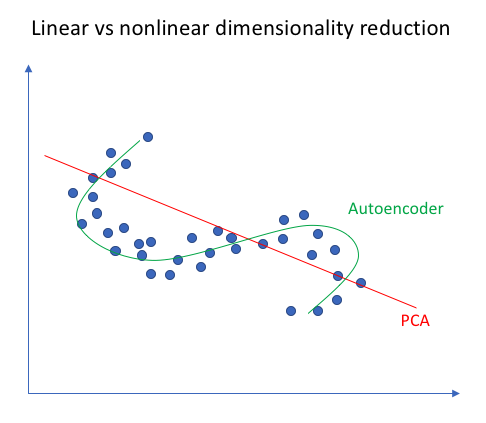

For higher dimensional data, autoencoders are capable of learning a complex representation of the data (manifold) which can be used to describe observations in a lower dimensionality and correspondingly decoded into the original input space.

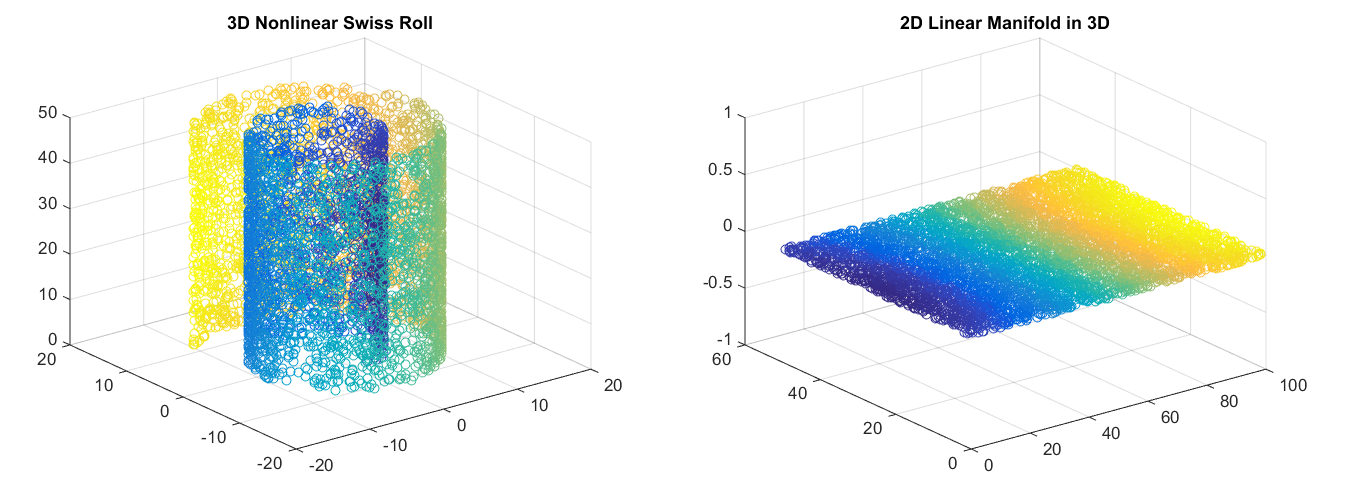

# 6: K-Means Clustering
In this section we will be clustering the borrowers using the K-Means algorithm.

The K-Means algorithm partitions the dataset into K distinct non-overlapping clusters and is as follows:

• Randomly assign 1 to K to each of the observations - these are the initial cluster assignments
• Iterate the following until the cluster assignments stop changing
- For each of the K clusters, compute the cluster centroid, the vector of the p feature means for the observations in the kth cluster
- Assign each observation to the cluster whose centroid is closest

In order to apply this algorithm we will use the sci-kit learn package, and then compare the results for each value of k, to the grades that Lending Club give to each borrower.

In [10]:
# it takes nearly 3 minutes to run this cell, please wait patientily
# keep a list of different borrower characteristics than before, adding grade to the dataframe for this section
df = pd.read_csv('../data/lendingclub_cleaned/Loan_data.csv', low_memory = False, index_col=0)
clist2 = ['loan_status', 'loan_amnt', 'int_rate', 'annual_inc', 'avg_cur_bal', 'emp_length', 'fico_range_high', 'delinq_amnt', 'revol_util','grade']
df = df[clist2] # filter out the dataframe keeping only columns specified in list

# turn loan_status into a default indicator
df['loan_status'] = (df['loan_status'] == 'Fail')

# Scale the data
X = (df.loc[:, df.columns != 'loan_status'] - df.loc[:, df.columns != 'loan_status'].mean())/df.loc[:, df.columns != 'loan_status'].std()
# iterate over the range of k, save predicted results to a dictionary
labels={}
centers={}
# only fit the variables specified in the brief (remove grade)
for k in range(1,11):
    labels[k]=KMeans(n_clusters=k,random_state = 123,n_init=10).fit(X.iloc[:,:-1]).labels_
    centers[k]=KMeans(n_clusters=k,random_state = 123,n_init=10).fit(X.iloc[:,:-1]).cluster_centers_
    
#X.iloc[:,:-1].shape # shape is 107280 rows, 8 columns
labels

{1: array([0, 0, 0, ..., 0, 0, 0]),
 2: array([1, 1, 0, ..., 1, 1, 1]),
 3: array([0, 0, 0, ..., 0, 0, 0]),
 4: array([0, 1, 0, ..., 1, 0, 1]),
 5: array([1, 0, 1, ..., 0, 4, 0]),
 6: array([3, 0, 3, ..., 4, 1, 4]),
 7: array([6, 4, 6, ..., 1, 0, 1]),
 8: array([5, 1, 0, ..., 6, 2, 6]),
 9: array([0, 8, 1, ..., 4, 6, 4]),
 10: array([6, 3, 1, ..., 4, 8, 4])}

Now we have a dictionary called "labels" which contains the cluster centroids for each value of K, from 1 to 10. In order to see if we're on the right track we can first visualise using PCA, reducing the dimensions and plotting the first principal component score against the second principal component score, to see if we have distinguishable clusters.

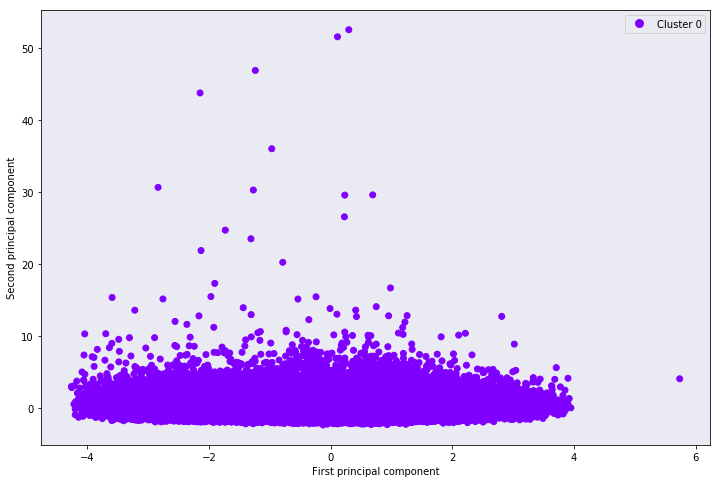

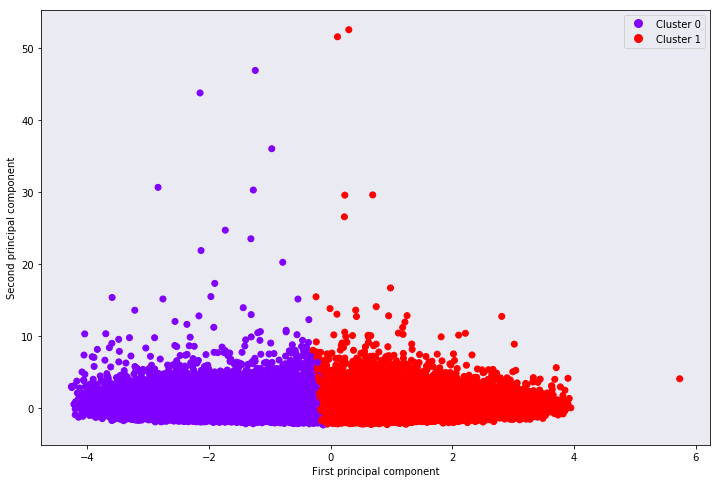

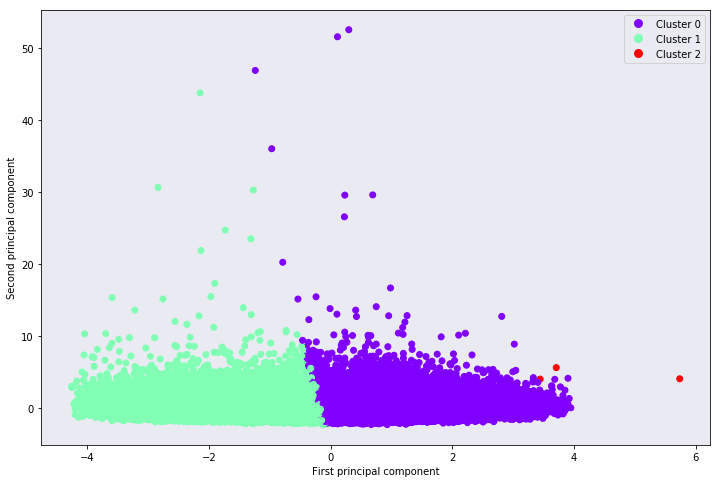

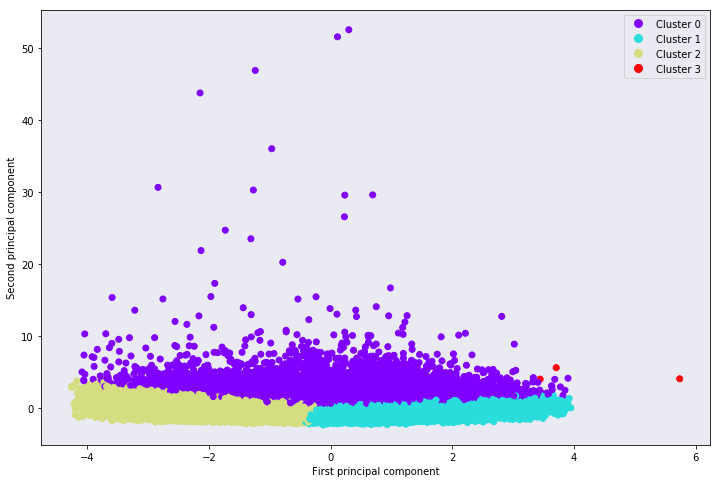

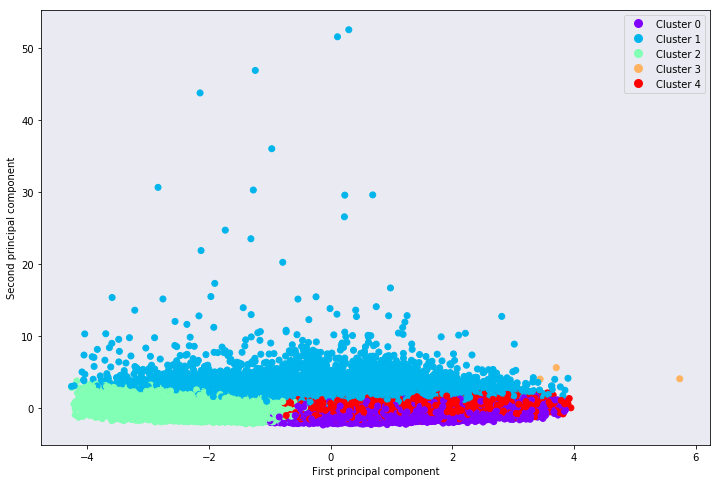

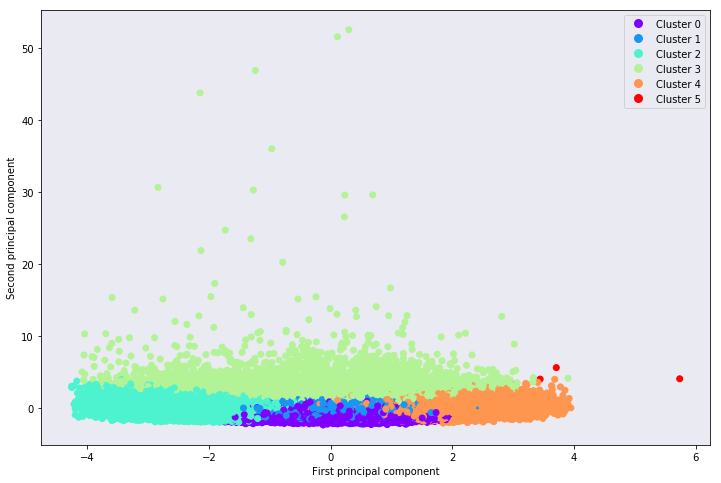

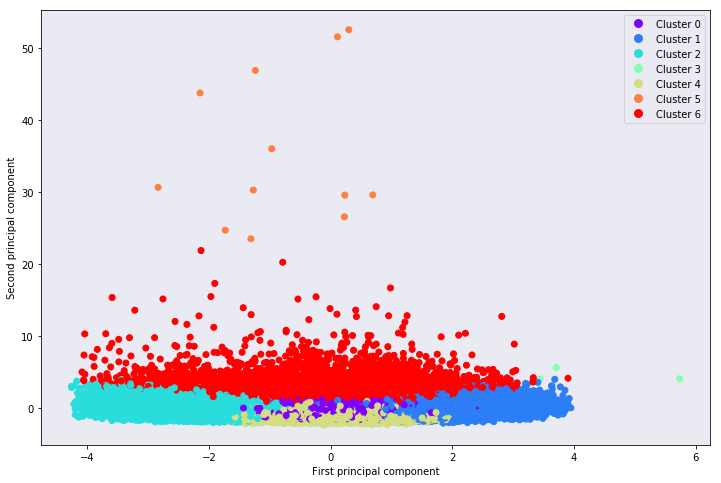

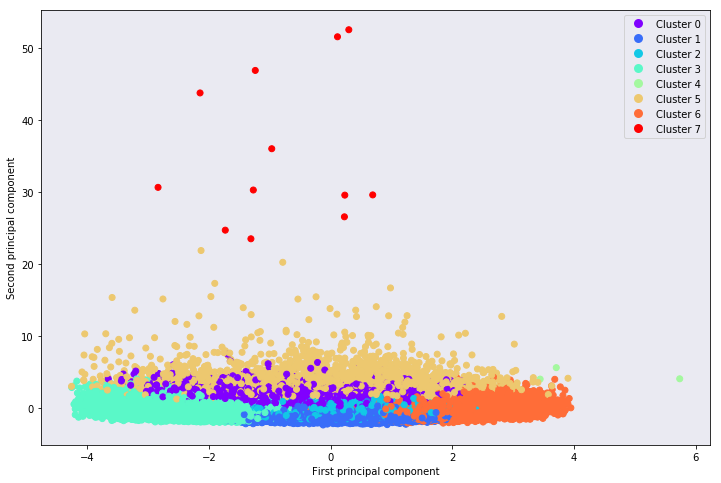

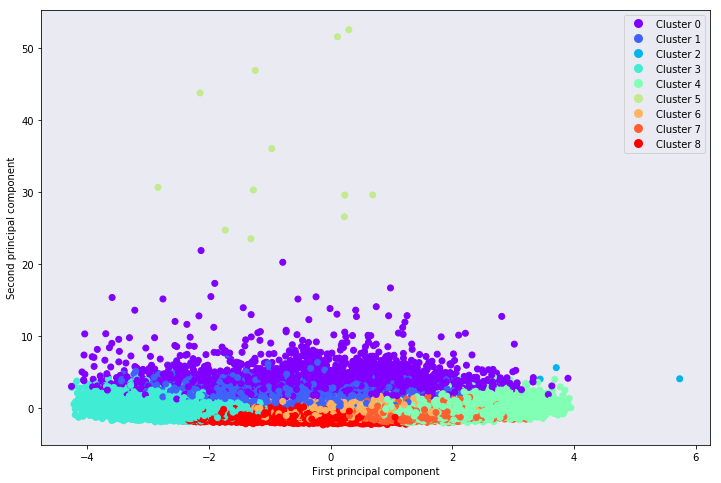

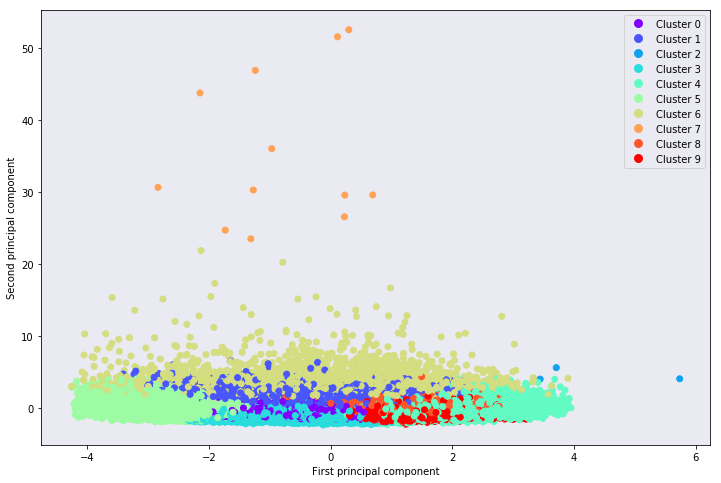

In [11]:
# it takes nearly 2 minutes to run this cell, please wait patientily
# Complete PCA on all columns except the grade/loan_status
pca = PCA(n_components=2)
Z = pca.fit_transform(X.iloc[:,:-1])
# iterate over each number of k from 1 to 10 and plot each
plt.rcParams['axes.facecolor'] = 'eaeaf2'
for k in range(1,11):
    plt.figure(figsize = (12,8))
    sc=plt.scatter(Z[:,0],Z[:,1],c=labels[k],cmap='rainbow') # rainbow for bigger contrast between clusters
    plt.xlabel('First principal component')
    plt.ylabel('Second principal component')
    lp = lambda i: plt.plot([],color=sc.cmap(sc.norm(i)), ms=np.sqrt(81), mec="none", # for creating a legend
                        label="Cluster {:g}".format(i), ls="", marker="o")[0]
    handles = [lp(i) for i in np.unique(labels[k])]
    plt.legend(handles=handles)

# 7: Tuning the number of clusters, K
<br>
<div style="text-align:justify;">
From the PCA visualisation above, there appears to be distinct clusters among the borrowers with only a small variation between k=2 and k=3. We can further test whether these clusters are providing informative patterns that emerge from the data or if we are forcing the different borrowers into clusters that don't differentiate from each other as much. </div>
<br>
<div style="text-align:justify;">
In order to do this we need to look at the within-cluster variation, which, for each cluster, is the sum of all the pairwise squared Euclidean distances (the dissimilarity measure used by the package) between the observations in the cluster, divided by the total number of observations in that cluster. The method is called the "elbow method", attempting to observe a kink in the curve that will point to the optimal amount of clusters.

#### Within-cluster variation

Text(0,0.5,'Within-cluster point variation')

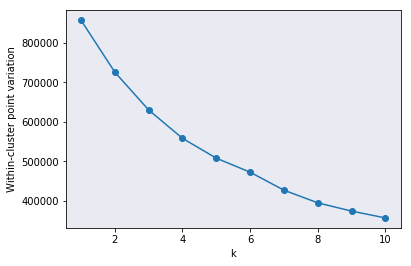

In [12]:
# it takes nearly 2 minutes to run this cell, please wait patientily
# define an array to save the within-cluster variations
within_cluster = []
# run the initialisation of the K-means algorithm 10 times, fit it to our dataframe (without grade column)
# from k=1 to k=10
# ensure same random state as above
for k in range(1,11): 
    fitted = KMeans(n_clusters=k,random_state = 123,n_init=10).fit(X.iloc[:,:-1])
    within_cluster.append(fitted.inertia_)
plt.plot(range(1,11),within_cluster,'-o')    
plt.xlabel('k')
plt.ylabel('Within-cluster point variation')

# inertia gives the sum of squared distances of samples to their closest cluster centroid

From the graph, the within-cluster variation decreases as we add more clusters, however the rate of decrease drops off at around $k=4$ to $k=5$, although there is another noticeable drop from $k=6$ to $k=7$. Beyond this point the within-cluster variation does not drop as much, indicating the creation of "fake" clusters which do not offer significant insights about patterns in the data. 

Nevertheless, the curve is quite smooth and there is no specific "elbow" or inflection in the curve, which may point to clustering not being the most suitable method to analyse the borrowers. We can confirm this using the `Calinski Harabasz` and `distortion` scores from the `yellowbrick` package.

#### Calinski Harabasz score

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000002674B8D57B8>,
                 k=None, metric=None, model=None, timings=False)

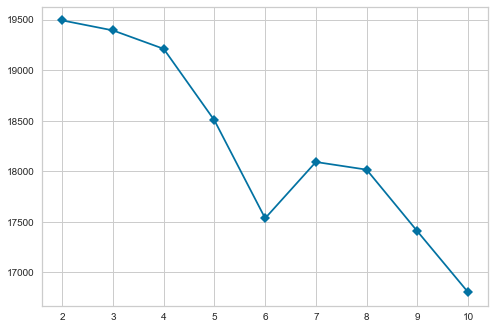

In [13]:
# it takes nearly 2 minutes to run this cell, please wait patientily
from yellowbrick.cluster import KElbowVisualizer
import warnings # depcrating warning from calinski harabasz because module name is misspelt and being changed soon
warnings.filterwarnings("ignore")

# First try the Calinski Harabasz score
calinski = KMeans(random_state = 123,n_init=10) # need to pass as function, ensure the random state and initialisation is the same
calinski_graph = KElbowVisualizer(calinski, k=(2,11), metric='calinski_harabaz', timings=False)
calinski_graph.fit(X.iloc[:,:-1])

#### Distortion score

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000002674BA42668>,
                 k=None, metric=None, model=None, timings=False)

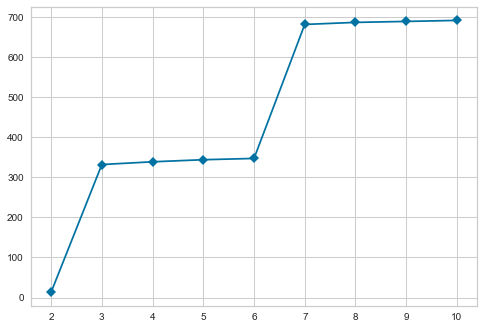

In [14]:
# it takes nearly 2 minutes to run this cell, please wait patientily
distortion = KMeans(random_state = 123,n_init=10) # ensure the random state and initialisation is the same
distortion_graph = KElbowVisualizer(distortion, k=(2,11), timings = False)
distortion_graph.fit(X.iloc[:,:-1])

#### Analysis

After seeing that the sum of squared distances for the clusters produced a somewhat smooth curve (`inertia_` parameter from sklearn), with it being difficult to determine the exact optimal number of clusters, we tried two alternative methods, first, the `Calinski Harabasz` score. 

The `Calinski Harabasz` score is given by the **ratio of between-to-within cluster variation**, where the between-cluster variation is given by the total sum of squared distances in the dataset (sum of squared distance from each point to each cluster center), minus the within-cluster variation defined earlier. The between-cluster variation measures the sum of squared distances from all of the cluster centroids to the data's centroid. The larger this is, the more spread out the clusters are. Additionally, from earlier we can see that the within-cluster variation will decrease as we increase the number of clusters. Therefore, in order to have more spread out, tight clusters, **the optimal amount of clusters is when this ratio is at its largest**. 

However, often the `Calinski Harabasz` gives k=2 as the optimal cluster number, and it is advised to search for the next local maximum as two clusters are often not ideal, especially in datasets that are particularly fragmented. The P2P lending sector is quite fragmented, with borrwers ranging from those looking to cover credit costs, and others looking to make large purchases on homes (`df['purpose'].value_counts()` inserted at the start of code sheds light on this, over 30,000 out of roughly 107,000 of the observations are for purchases other than debt consolidation and credit cards). Therefore, **the next local maximum is given by $k=7$**, which we conjectured previously was an optimal number of clusters. The Calinski-Harabasz score seems to indicate that there is a meaningful clustering of customers at $k=7$, and while earlier values of $k$ have higher scores, they do not appear to be significant clusters, and since the sector is quite fragmented, perhaps a larger number of clusters would be better to analyse.

The `distortion` score differs from our within-cluster variation as it is the mean sum of squared distances to the cluster centroids, rather than the total. We see that the `distortion` score increases with the amount of clusters but we see two large jumps at $k=2$ to $k=3$ and $k=6$ to $k=7$. When the number of clusters transitions from 2 to 3, we observe a shift in the classification of the points into clusters, visualised with PCA in question 6. More specifically, the two main clusters split down a vertical axis instead become three clusters, with two split down a similar vertical axis, and another cluster with a very small amount of observations. Considering the new cluster created has a very small amount of observations, it is difficult to see this as a significant clustering organisation. In the within-cluster graph, we also saw a small kink at k=6, and this is repeated in the distortion score, this time with a large jump. It appears that **$k=7$ is also a suitable number of clusters** from the distortion score, therefore,  **we will use $K^{*}=7$ moving forward**.

## Compare with Lending Club grades

The data provided also includes Lending Club's own grades given to customers. A good exercise will be to test whether the K-Means unsupervised learning method groups customers into different clusters than Lending Club's own risk assessments, and what economics insights we can gain from this. We will use the optimal cluster number of $K^*=7$.

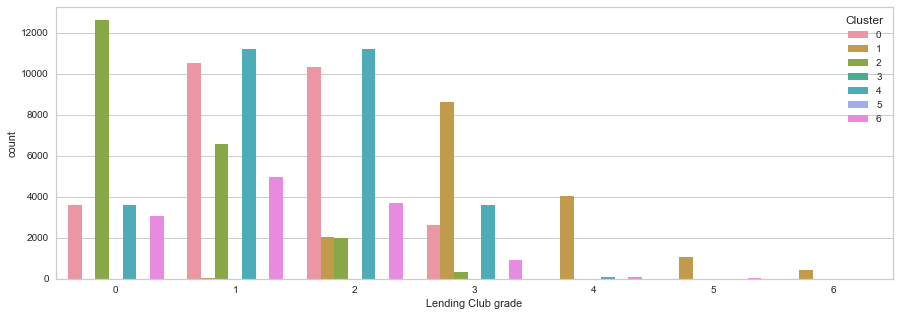

In [15]:
# Use seaborn to make a countplot, where for each Lending Club grade, we plot the four clusters
# i.e. how many borrowers in each Lending Club grade were assigned a specific cluster
plt.figure(figsize=(15,5))
sns.countplot(df['grade'].values,hue=labels[7])
plt.xlabel('Lending Club grade')
plt.legend(title='Cluster')

From the countplot we see there is great variation between our clusters and the grades, since even though the number of clusters (7) is exactly the same as the number of grades (7) (which is interesting to note, that LC have 'clustered' their customers into the same number of fragments), some of our clusters span several LC grades, meaning they contain different information than the LC grade contains. We can analyse this graph cluster-by-cluster.

#### Cluster 0

Cluster 0 is the tightly packed purple cluster in our previous visualisations that has a small first PC and second PC score. However, it appears to correlate with LC grades 1 and 2 the most, which the majority of borrowers fall into. Cluster 4 seems to match well with cluster 0 for the LC grade, so the biplot is needed to break these clusters down further.

#### Cluster 1

Our second cluster (which is the large bottom right cluster in question 6 graphs (large first PC, small second PC) is spread among LC grades 2 to 6, with its dominant LC grades being 3 and 4. This cluster appears to hold the borrowers that LC believes are less credit-worthy than the average borrower.

#### Cluster 2

Our third cluster (which is the large bottom left cluster in question 6 graphs (large (negative) first PC, small second PC)) is spread among the first four LC grades, with its dominance in LC grade 0. Firstly, this indicates that the vast majority of borrowers that *Lending Club* think are the **most** credit worthy (grade 0) can be found in cluster 2 (third cluster). 

#### Cluster 3

Cluster 3 is one with a very small number of observations, making it difficult to interpret, however it uniquely has both a high first PC and second PC, so analysing the clusters and borrower characteristics using the biplot may provide more answers about this cluster.

#### Cluster 4

Cluster 4 sits below cluster 0 in the PCA dimension-reduced graphs and matches well with it in terms of LC grade assignment. They both cover the same LC grades, so it appears that the clustering algorithm has distinguished these two clusters from each other while LC has been unable to. The biplot will reveal more information on the differences between these two clusters.

#### Cluster 5

Cluster 5 contains a small amount of observations, similar to cluster 3, however it has the highest second PC scores out of the dataset, so once the biplot indicates the nature of each principal component, it will be easier to identify this cluster.

#### Cluster 6

The final cluster is the largest cluster (in terms of size) and spans the domain of the first PC with a relatively high second PC score. It is one of the most interesting clusters as it also seems to span multiple LC grades, meaning that it contains information that the LC grade does not encapsulate. Further biplot analysis will yield what this information is.

## Analysing the clusters using biplots

In order to analyse the cluster visualisation from PCA with 2 components in question 6 above, we can create biplots. First, we need the loadings for each of the different borrwer characteristics, and then we will be able to see from the biplot how each behave and any economic arguments we can make about them.

In [16]:
# get the loadings on each of the 8 borrowers characteristics
# calling the components from the fitted PCA object (pca), thenn creating a dataframe with these components, labelling them PC1 and PC2
# use the column names from X (without grade), then add these to a list
loadings = pd.DataFrame(pca.components_[0:2],index=['PC1','PC2'],columns = X.iloc[:,:-1].columns)
# create a list of the 8 characteristics to create the biplot
terms = list(loadings)
loadings

,loan_amnt,int_rate,annual_inc,avg_cur_bal,emp_length,fico_range_high,delinq_amnt,revol_util
PC1,0.014471,0.544340,-0.020274,-0.001298,0.010382,-0.615533,0.016714,0.569038
PC2,0.528036,-0.058848,0.569242,0.561783,0.200389,0.098662,0.017470,0.166983


Text(0,0.5,'Second principal component')

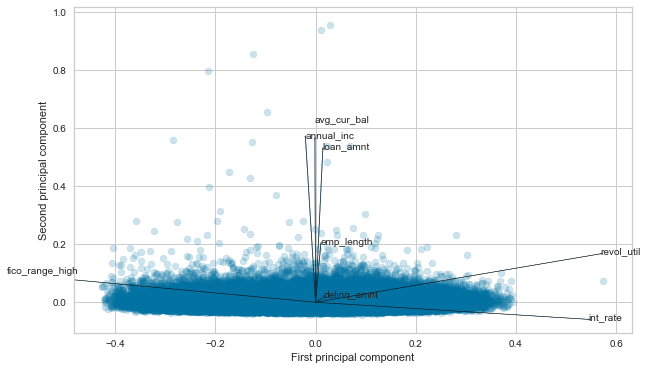

In [17]:
# replot the biplot to compare directly side by side with our clusters
% matplotlib inline
plt.figure(figsize=(10,6))
for term in terms: # loop over each of our borrower characteristics
    # include these conditionals to clear up the labelling slightly
    if term in ["avg_cur_bal","annual_int","loan_inc"]:
        plt.arrow(0,0,loadings.loc['PC1',term],loadings.loc['PC2',term])
        plt.text(loadings.loc['PC1',term],1.1*loadings.loc['PC2',term],term)
    else:
        plt.arrow(0,0,loadings.loc['PC1',term],loadings.loc['PC2',term])
        plt.text(loadings.loc['PC1',term],loadings.loc['PC2',term],term)
plt.scatter(Z[:,0]/(Z[:,0].max() - Z[:,0].min()) ,Z[:,1]/(Z[:,1].max() - Z[:,1].min()),alpha = 0.2)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')

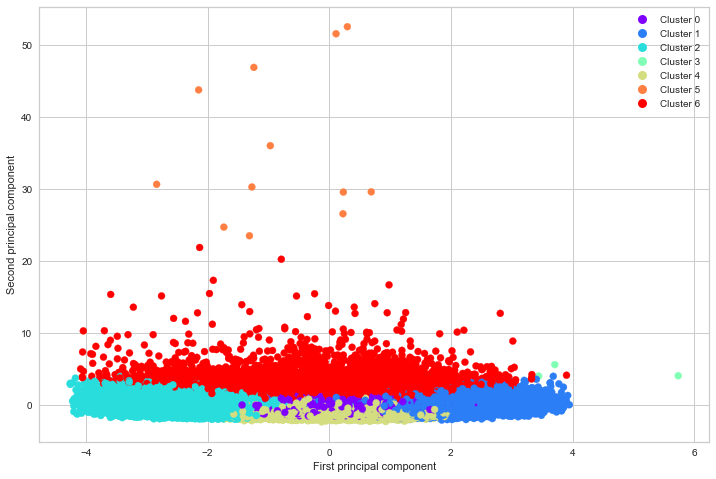

In [18]:
# Replot the K*=7 cluster visualisation
plt.figure(figsize=(12,8))
sc=plt.scatter(Z[:,0],Z[:,1],c=labels[7],cmap='rainbow')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
lp = lambda i: plt.plot([],color=sc.cmap(sc.norm(i)), ms=np.sqrt(81), mec="none", # for creating a legend
                        label="Cluster {:g}".format(i), ls="", marker="o")[0]
handles = [lp(i) for i in np.unique(labels[7])]
plt.legend(handles=handles)

### Determining the type of borrowers in each cluster

From the biplot analysis in question 1, we can use information from the first PC to determine the clusters of borrowers. In question 6 we can see how each cluster is distributed among the first two principal components for $K^*=7$, shown again above.

#### Cluster 0

Cluster 0 in the above visualisation is the small pocket of observations with a first and second PC value of close to zero. Therefore, it is possible that different borrower characteristics would need to be incorporated into the biplot to determine the economic significance of this group of borrowers, as they seem to not be driven by credit history/usage and financial stability. 

#### Cluster 1

Cluster 1 in the above visualisation is the bottom right large cluster, with a large first PC score and a small second PC score. Therefore, **borrowers in cluster 1 have a range of financial stabilities but similar credit histories, specifically revolving utilisation and interest rate given to them**. The group of characteristics driving the first PC were credit histories or credit utilisation, and since this cluster scores highly on the first PC, it is likely that these factors also drive the clustering of these borrowers, and so have similar credit histories. It is reasonable for borrowers of different financial stability to have different credit pasts, since wealth can be accumulated over time, people get paid more over time, but they may have had credit spirals in order to eventually stabilise. Also, a borrower which is financially stable may still utilise credit for large projects (over 30% of borrowers in the dataset were borrowing for reasons other than debt consolidation and credit cards), again indicating that financial stability does not need to be correlated to credit history or usage.

The LC grades that were dominated by cluster 1 borrowers were grades 3 and 4, the borrowers that LC deem to be less credit-worthy than the average, so it's possible that this cluster of borrowers with similar credit histories, have high revolving utilisation and were certainly given higher interest rates (as LC grade correlates directly with interest rate).

#### Cluster 2

Cluster 2 in the above visualisation is the bottom left large cluster, with a large (negative) first PC score and a small second PC score. **Borrowers in cluster 2 have a range of financial stabilities but similar credit histories, specifically FICO upper range scores**. As mentioned before, the FICO score is negatively correlated with revolving utilisation and interest rate but is the most important factor in calculating the first PC. Since cluster 2 has a large absolute first PC score, this cluster of borrowers have similar FICO scores. Similarly with cluster 1, a borrower can have a high FICO score yet not be financially stable, as FICO scores are calculated using primarily historical information.

From the LC grade analysis, we can see that the borrowers in this cluster are assessed by LC to be *the most credit-worthy borrowers* with LC grade 0 being dominated by borrowers from this cluster. This suggests that, if we take LC grade's as an indicator, cluster 2 contains borrowers with high FICO scores, as FICO scores correlates well with LC grade.

#### Cluster 3

Cluster 3 contains a very small amount of observations, with relatively high first PC and second PC scores. Given its unique configuration this cluster is more difficult to ascertain, but following our interpretation of the principal components, we can say that the borrowers in this cluster have **both similar financial stabilities and credit histories**. The lack of observations also makes it difficult to analyse this cluster using the LC grade. From the PC analysis, the revolving utilisation correlated slightly more with the financial stability factors then interest rate, so it may be the case that this cluster includes borrowers with similar revolving utilisations and financial stabilities, rather than interest rates.

#### Cluster 4

Cluster 4 sits below cluster 0, with the difference being that cluster 4 observations have a wider range of first PC scores and a slightly smaller second PC score. Given this, we can deduce that cluster 4 contains borrowers which have slightly similar financial stabilities (not as strong as clusters 5 and 6) but a range of credit histories. It is likely that there are other borrower characteristics at play which determines the economic significance of this cluster.

#### Cluster 5

Cluster 5 also contains a smaller amount of observations but quite clearly have a very strong second PC score, with a relatively negative first PC score. **Therefore, the main factor driving this cluster is financial stability**, much more than any of the other clusters, so that these borrowers have very similar loan amounts, average current balances, annual income and employment length, with some small similarity in credit histories. We are unable to analyse this cluster in terms of LC grade due to its small cardinality.

#### Cluster 6

Cluster 6 in the above visualisation is the cluster which spans the domain of the first PC, and also varies along the second PC axis. The first conclusion we can make, based on the above analysis, is that **borrowers in cluster 0 have a range of credit histories, but similar financial stability**. The main group of characteristics defining this cluster are the annual income, average current balance, loan amount and employment length which we grouped as financial stability indicators. Cluster 0 is relatively large on the second PC, while it has a range of values for the first PC, so in general borrowers in this cluster have similar financial stabilities. This insight can explain the disparity between the Lending Club grade and our clusters.

Earlier we stated that cluster 6 was distributing among the first four LC grades relatively evenly, without dominating a particular LC grade. From the PC analysis and biplot, we can see that the reason is because financial stability is uncorrelated with the credit history of the borrower, and credit history will reasonably play a very large part of the LC grade, which explains why cluster 6 spans many different LC grades.